# 7.5 批量规范化

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。 在本节中，我们将介绍批量规范化（batch normalization），这是一种流行且有效的技术，可持续加速深层网络的收敛速度。再结合在7.6节中将介绍的残差块，批量规范化使得研究人员能够训练100层以上的网络。

## 7.5.1 训练深层神经网络

为什么需要批量规范化层呢？让我们来回顾一下训练神经网络时出现的一些实际挑战。

首先，数据预处理的方式通常会对最终结果产生巨大影响。 回想一下我们应用多层感知机来预测房价的例子。使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。 直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。  

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。 接下来，我们应用比例系数和比例偏移。 正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

请注意，如果我们尝试使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。 这是因为在减去均值之后，每个隐藏单元将为0。 所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 请注意，在应用批量规范化时，批量大小的选择可能比没有批量规范化时更重要。

## 7.5.2 批量规范化层

回想一下，批量规范化和其他层之间的一个关键区别是，由于批量规范化在完整的小批量上运行，因此我们不能像以前在引入其他层时那样忽略批量大小。 我们在下面讨论这两种情况：全连接层和卷积层，他们的批量规范化实现略有不同。

### 7.5.2.1 全连接层

通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。

### 7.5.2.2 卷积层

同样，对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。 当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。 假设我们的小批量包含个m样本，并且对于每个通道，卷积的输出具有高度p和宽度q。 那么对于卷积层，我们在每个输出通道m * p * q的个元素上同时执行每个批量规范化。 因此，在计算平均值和方差时，我们会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

### 7.5.2.3 预测过程中的批量规范化

批量规范化在训练模式和预测模式下的行为通常不同。 首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。 其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。 一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。 可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不一样的。

## 7.5.3 从零实现

下面，我们从头开始实现一个具有张量的批量规范化层。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

我们现在可以创建一个正确的BatchNorm层。 这个层将保持适当的参数：拉伸gamma和偏移beta,这两个参数将在训练过程中更新。 此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

撇开算法细节，注意我们实现层的基础设计模式。 通常情况下，我们用一个单独的函数定义其数学原理，比如说batch_norm。 然后，我们将此功能集成到一个自定义层中，其代码主要处理数据移动到训练设备（如GPU）、分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和方差）等问题。 为了方便起见，我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。 不用担心，深度学习框架中的批量规范化API将为我们解决上述问题，我们稍后将展示这一点。

In [2]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 7.5.4 使用批量规范化层的LeNet

为了更好理解如何应用BatchNorm，下面我们将其应用于LeNet模型。 回想一下，批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的。

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

和以前一样，我们将在Fashion-MNIST数据集上训练网络。 这个代码与我们第一次训练LeNet时几乎完全相同，主要区别在于学习率大得多。

loss 0.272, train acc 0.900, test acc 0.603
34195.4 examples/sec on cuda:0


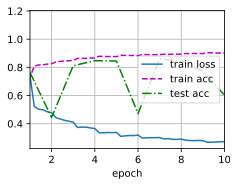

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

让我们来看看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta。

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.1192, 4.6591, 2.1452, 0.5112, 3.1519, 2.8494], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-3.2466,  2.6529,  2.0724,  0.2154,  1.5318,  0.9650], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## 7.5.5 简明实现

除了使用我们刚刚定义的BatchNorm，我们也可以直接使用深度学习框架中定义的BatchNorm。 该代码看起来几乎与我们上面的代码相同。

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

下面，我们使用相同超参数来训练模型。 请注意，通常高级API变体运行速度快得多，因为它的代码已编译为C++或CUDA，而我们的自定义代码由Python实现。

loss 0.265, train acc 0.903, test acc 0.872
76035.3 examples/sec on cuda:0


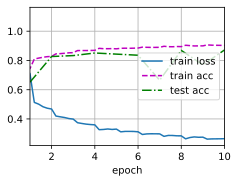

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.5.7 小结

·在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。

·批量规范化在全连接层和卷积层的使用略有不同。

·批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。

·批量规范化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。